In [4]:
import os
import cv2
from tqdm import tqdm
from random import sample
from PIL import Image
import pickle
import time
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset

from sklearn.metrics import accuracy_score
from sklearn import svm, metrics, preprocessing


### Обзор данных

In [ ]:
train_dir = '/kaggle/input/driver-gaze-in-the-wild/dgw/dgw/train'
val_dir = '/kaggle/input/driver-gaze-in-the-wild/dgw/dgw/val'

In [ ]:
def get_data_info(directory: str) -> tuple:
    subjects = set()
    number_of_frames = 0
    
    annotation_file = pd.DataFrame({'Кадр': [], 'Класс': []})

    for target in tqdm(os.listdir(directory)):
        file_dir = directory + '/' + target
        for filename in os.listdir(file_dir):
            f = os.path.join(file_dir, filename)

            if os.path.isfile(f):
                number_of_frames += 1
                
                annotation_file.loc[len(annotation_file.index)] = [f, int(target) - 1]
                
                sub_id_start = f.lower().rfind('sub') + 3
                sub_id = ''

                for letter in range(sub_id_start, len(f)):
                    if f[letter] != '_':
                        sub_id += f[letter]
                    else:
                        break
                if len(sub_id) == 0: print(f)
                elif len(sub_id) > 3: print(f)
                subjects.add(int(sub_id))
                
    return subjects, number_of_frames, annotation_file
     
train_subjects, train_number_of_frames, train_annotation = get_data_info(train_dir)
val_subjects, val_number_of_frames, val_annotation = get_data_info(val_dir)

In [ ]:
len(train_subjects), len(val_subjects), len(train_subjects) + len(val_subjects)

In [ ]:
train_number_of_frames, val_number_of_frames

Разметка:

- 1 - левая верхняя часть лобового стекла
- 2 - прямо перед собой
- 3 - спидометр
- 4 - радио 
- 5 - правая верхняя часть лобового стекла
- 6 - правая нижняя часть лобового стекла
- 7 - правое боковое зеркало
- 8 - зеркало заднего вида
- 9 - левое боковое зеркало

In [ ]:
frame_num_df = pd.DataFrame({'Выборка': [], 'Часть': [], 'Число кадров': []})

for i in range(1, 10):
    frame_num_df.loc[len(frame_num_df.index)] = ['train', i, len(os.listdir(train_dir + '/' + str(i)))] 
    
for i in range(1, 10):
    frame_num_df.loc[len(frame_num_df.index)] = ['val', i, len(os.listdir(val_dir + '/' + str(i)))] 

In [ ]:
plt.figure(figsize=(8,4))
plt.title('Распределение кадров по классам в train')
sns.barplot(x = 'Часть', y = 'Число кадров', data = frame_num_df[frame_num_df['Выборка'] == 'train'].iloc[:, 1:])

plt.figure(figsize=(8,4))
plt.title('Распределение кадров по классам в val')
sns.barplot(x = 'Часть', y = 'Число кадров', data = frame_num_df[frame_num_df['Выборка'] == 'val'].iloc[:, 1:])

In [ ]:
frame_num_df['Число кадров'].sum() == train_number_of_frames + val_number_of_frames

### Извлечение лиц

In [ ]:
!pip install facenet-pytorch
from facenet_pytorch import MTCNN # pretrained model for image recognition

In [ ]:
mtcnn = MTCNN(keep_all=True, min_face_size=40, device='cuda')

In [ ]:
# from shutil import copyfile

# copyfile(src = "../input/mtcnn-model/facial_analysis_kaggle.py", dst = "../working/facial_analysis_kaggle.py")
# copyfile(src = "../input/mtcnn-model/mtcnn.pb", dst = "../working/mtcnn.pb")

In [ ]:
# from facial_analysis_kaggle import FacialImageProcessing

# imgProcessing = FacialImageProcessing(False)
# mtcnn = MTCNN(keep_all=True, min_face_size=40, device='cpu')

In [ ]:
def save_faces(source_path, save_path):
    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.makedirs(os.path.join(save_path, folder))

        for image in os.listdir(os.path.join(source_path, folder)):
            filename = os.path.join(source_path, folder, image)
            frame_bgr = cv2.imread(filename)
            frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            # bounding_boxes, _ = imgProcessing.detect_faces(frame)
            bounding_boxes, _, _ = mtcnn.detect(frame, landmarks=True)

            if bounding_boxes is None or len(bounding_boxes)==0:
                print('No faces found for ',filename)
                face_img = frame_bgr
                faceFound='noface'
            else:
                if len(bounding_boxes)>1:
                    print('Too many faces (',len(bounding_boxes),') found for ',filename)
                    bounding_boxes=bounding_boxes[:1]

                b=[int(bi) for bi in bounding_boxes[0]]
                x1,y1,x2,y2=b[0:4]
                face_img=frame_bgr[y1:y2,x1:x2,:]

                if np.prod(face_img.shape)==0:
                    print('Empty face ',b,' found for ',filename)
                    continue

                faceFound=''

            #face_img=cv2.resize(face_img,INPUT_SIZE)
            root,ext=os.path.splitext(image)
            cv2.imwrite(os.path.join(save_path, folder, root+faceFound+ext), face_img) 

In [ ]:
save_faces(train_dir, '/kaggle/working/train_faces')

In [ ]:
save_faces(val_dir, '/kaggle/working/val_faces')

In [ ]:
# import shutil
# shutil.rmtree("/kaggle/working/train_faces")

### Смотрим на лица

In [ ]:
на каком количестве кадров лицо не было детектировано

In [5]:
train_faces_dir = '/kaggle/input/driver-gaze-in-the-wild/dgw_faces/dgw_faces/train_faces'
val_faces_dir = '/kaggle/input/driver-gaze-in-the-wild/dgw_faces/dgw_faces/val_faces'

In [7]:
def get_faces_info(directory: str) -> tuple:
    number_of_faces = 0
    no_face_frames = 0
    annotation_file = pd.DataFrame({'Кадр': [], 'Класс': []})
    
    for target in tqdm(os.listdir(directory)):
        file_dir = directory + '/' + target
        for filename in os.listdir(file_dir):
            f = os.path.join(file_dir, filename)

            if os.path.isfile(f):
                number_of_faces += 1
                
                if 'noface' in f:
                    no_face_frames += 1
                    annotation_file.loc[len(annotation_file.index)] = [f, 'noface']
                else:
                    annotation_file.loc[len(annotation_file.index)] = [f, int(target) - 1]
                
    return number_of_faces, no_face_frames, annotation_file

train_num_of_faces, train_num_of_noface, train_faces_annotation_file = get_faces_info(train_faces_dir)
val_num_of_faces, val_num_of_noface, val_faces_annotation_file = get_faces_info(val_faces_dir)

  0%|          | 0/9 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
train_num_of_faces, val_num_of_faces

In [ ]:
train_num_of_noface, val_num_of_noface - 11, 1 - незначительное количество, но необходимо убрать эти кадры

In [ ]:
train_faces_annotation_file = train_faces_annotation_file[train_faces_annotation_file['Класс'] != 'noface']
val_faces_annotation_file = val_faces_annotation_file[val_faces_annotation_file['Класс'] != 'noface']

In [ ]:
train_faces_annotation_file.shape, val_faces_annotation_file.shape

In [ ]:
train_faces_annotation_file['Класс'] = train_faces_annotation_file['Класс'].astype(int)
val_faces_annotation_file['Класс'] = val_faces_annotation_file['Класс'].astype(int)

In [ ]:
train_faces_annotation_file['Субъект'] = train_faces_annotation_file['Кадр'] \
.apply(lambda x: int(x[x.lower().rfind('sub') + 3:].split('_')[0]))

val_faces_annotation_file['Субъект'] = val_faces_annotation_file['Кадр'] \
.apply(lambda x: int(x[x.lower().rfind('sub') + 3:].split('_')[0]))

In [ ]:
train_faces_subjects = train_faces_annotation_file['Субъект'].unique()
val_face_subjects = val_faces_annotation_file['Субъект'].unique()

set(train_faces_subjects) & set(val_face_subjects) # отсутствуют одинаковые люди в train и val

In [ ]:
test_face_subjects = np.random.choice(train_faces_subjects, 40, replace = False)

In [ ]:
test_face_subjects = [ 62,  42,  29, 270, 267, 190,  59,  76,  58,  40,   6,  17,  20,
        46,  19, 194, 198,   2,  81,  60,  10,  27,  54,  37, 189,  70,
        89,  51, 195,  72,  50, 261,  16, 262,  57,  92,  78, 276, 265,
        82]

In [ ]:
test_faces_annotation_file = train_faces_annotation_file[train_faces_annotation_file['Субъект'].isin(test_face_subjects)]
test_faces_annotation_file.reset_index(drop = True, inplace = True)

train_faces_annotation_file = train_faces_annotation_file[~(train_faces_annotation_file['Субъект'].isin(test_face_subjects))]
train_faces_annotation_file.reset_index(drop = True, inplace = True)

In [ ]:
set(test_faces_annotation_file['Субъект'].unique()) \
& set(train_faces_annotation_file['Субъект'].unique()) # пересечений между субъектами нет

In [ ]:
train_faces_annotation_file['Класс'].hist()

In [ ]:
val_faces_annotation_file['Класс'].hist()

In [ ]:
test_faces_annotation_file['Класс'].hist()

In [2]:
import pickle 

In [ ]:
with open('/kaggle/working/dgw_train_faces_annotation', 'wb') as handle:
    pickle.dump(train_faces_annotation_file, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(handle) 
    
with open('/kaggle/working/dgw_val_faces_annotation', 'wb') as handle:
    pickle.dump(val_faces_annotation_file, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(handle) 
    
with open('/kaggle/working/dgw_test_faces_annotation', 'wb') as handle:
    pickle.dump(test_faces_annotation_file, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(handle) 

In [6]:
with open(r"/kaggle/input/dgw-faces-annotation/dgw_train_faces_annotation", "rb") as input_file:
    train_annotation = pickle.load(input_file)
    
with open(r"/kaggle/input/dgw-faces-annotation/dgw_val_faces_annotation", "rb") as input_file:
    val_annotation = pickle.load(input_file)
    
with open(r"/kaggle/input/dgw-faces-annotation/dgw_test_faces_annotation", "rb") as input_file:
    test_annotation = pickle.load(input_file)

### Датасет с лицами

In [7]:
class DriverFaces(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotation_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        face = cv2.imread(img_path, cv2.IMREAD_COLOR)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            face = self.transform(face)
        if self.target_transform:
            label = self.target_transform(label)
        return face, int(label)

In [ ]:
# alexnet, inceprion_v1
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     # torchvision.transforms.Grayscale(),
     torchvision.transforms.Resize((224, 224)),
     torchvision.transforms.RandomHorizontalFlip(p=1)])

In [8]:
# enet_b0
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((260, 260)),
        torchvision.transforms.RandomHorizontalFlip(p = 1),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [9]:
train_faces = DriverFaces(train_annotation, train_faces_dir, transform)
val_faces = DriverFaces(val_annotation, val_faces_dir, transform)
test_faces = DriverFaces(test_annotation, train_faces_dir, transform)

torch.Size([3, 260, 260])
1


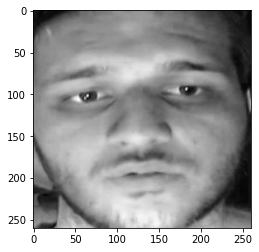

In [10]:
figure = plt.figure()

sample_idx = torch.randint(len(test_faces), size=(1,)).item()
img, label = test_faces[sample_idx]
print(img.shape)
print(label)
plt.imshow(img[0], cmap="gray")
plt.show()

### Train, Val, Test split

In [30]:
train_face_loader = torch.utils.data.DataLoader(train_faces, batch_size = 64, num_workers=2, shuffle = True)
val_face_loader = torch.utils.data.DataLoader(val_faces, batch_size = 64, num_workers=2, shuffle = False)
test_face_loader = torch.utils.data.DataLoader(test_faces, batch_size = 64, num_workers=2, shuffle = False)

Feature batch shape: torch.Size([64, 3, 260, 260])
Labels batch shape: torch.Size([64])


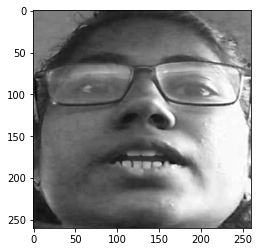

Label: 2


In [31]:
train_face_loader_iter = iter(train_face_loader)
train_features, train_labels = next(train_face_loader_iter)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

### Обучение

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
    logger = None,
    cur_epoch = None
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    N = len(data_loader)
    with tqdm(total=N, file=sys.stdout) as prbar:
        for iter, (images, labels) in enumerate(data_loader):
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            # print(predicted)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            '''prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )'''
            prbar.update(1)

            if logger is not None:
                logger.add_scalar('Train/loss', loss, cur_epoch*N + iter)
                logger.add_scalar('Train/accuracy', accuracy, cur_epoch*N + iter)

            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    # print(total_loss, num_batches)
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    # print((total_predictions == total_labels).mean())

    print(
        f"Loss: {round(metrics['loss'], 4)} "
        f"Accuracy: {round(metrics['accuracy'] * 100, 4)}"
    )
    
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

In [34]:
def validate(model, data_loader, criterion, device="cuda:0", logger=None, cur_epoch=None):
    model = model.to(device).eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    N = len(data_loader)
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for iter, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            # prbar.set_description(
            #     f"Loss: {round(loss.item(), 4)} "
            #     f"Accuracy: {round(accuracy.item() * 100, 4)}"
            # )
            prbar.update(1)

            '''if logger is not None:
                logger.add_scalar('Train/loss', loss, cur_epoch*N + iter)
                logger.add_scalar('Train/accuracy', accuracy, cur_epoch*N + iter)'''
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    # print(total_loss, num_batches)    
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})

    print(
        f"Loss: {round(metrics['loss'], 4)} "
        f"Accuracy: {round(metrics['accuracy'] * 100, 4)}"
    )
    return metrics

In [35]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion,
    device="cuda:0",
    log_dir=None
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []

    if log_dir is not None:
        writer = SummaryWriter(log_dir=log_dir)
    else:
        writer = None

    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device,
            logger = writer,
            cur_epoch = epoch
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion,
                logger = writer,
                cur_epoch = epoch
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])

#### Alexnet

In [ ]:
alexnet = torchvision.models.alexnet(pretrained = False)
alexnet.classifier[6] = nn.Linear(4096, 9)

alexnet.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(alexnet.parameters(), lr=0.001)

In [ ]:
import time
import sys

In [ ]:
num_epoch = 3
start = time.time()

fit(alexnet, num_epoch, train_face_loader, val_face_loader, optimizer, criterion, device=device)
print('Время с batch_size = 64: ', time.time() - start)

### Валидация

In [62]:
from sklearn.metrics import classification_report

In [17]:
def test(model, data_loader, criterion, device="cuda:0", logger=None, cur_epoch=None):
    model = model.to(device).eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    N = len(data_loader)
    
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for iter, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            prbar.update(1)

            '''if logger is not None:
                logger.add_scalar('Train/loss', loss, cur_epoch*N + iter)
                logger.add_scalar('Train/accuracy', accuracy, cur_epoch*N + iter)'''
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
        
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    
    # cl_report = classification_report(total_predictions, total_labels)
    
    print(
        f"Loss: {round(metrics['loss'], 4)} "
        f"Accuracy: {round(metrics['accuracy'] * 100, 4)}"
    )
    return metrics, total_predictions, total_labels

In [ ]:
with torch.no_grad():
    validation_metrics, y_pred, y_true = test(
        model=alexnet,
        data_loader=test_face_loader,
        criterion=criterion
    )

In [ ]:
confusion = pd.crosstab(y_true, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion.columns = target
confusion.index = target

In [ ]:
fig = plt.figure(figsize=(50,8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

In [ ]:
alexnet_1 = torchvision.models.alexnet(pretrained = False)
alexnet_1.classifier[6] = nn.Linear(4096, 9)
if device == 'cuda:0':
    alexnet_1.to(device)
alexnet_1.load_state_dict(torch.load('/kaggle/input/dgw-models/alexnet_1.h5'))
alexnet_1.eval()

In [ ]:
with torch.no_grad():
    validation_metrics, y_pred, y_true = test(
        model=alexnet_1,
        data_loader=val_face_loader,
        criterion=criterion
    )

In [ ]:
print(classification_report(y_pred, y_true)) # Loss: 1.6108 Accuracy: 51.1989

In [ ]:
alexnet_2 = torchvision.models.alexnet(pretrained = False)
alexnet_2.classifier[6] = nn.Linear(4096, 9)
if device == 'cuda:0':
    alexnet_2.to(device)
alexnet_2.load_state_dict(torch.load('/kaggle/input/dgw-models/alexnet_51_1989.h5'))
alexnet_2.eval()

In [ ]:
with torch.no_grad():
    validation_metrics, y_pred, y_true = test(
        model=alexnet_2,
        data_loader=test_face_loader,
        criterion=criterion
    )

In [18]:
target = ['левая верхняя часть лобового стекла','прямо перед собой','спидометр', 'радио',
            'правая верхняя часть лобового стекла','правая нижняя часть лобового стекла', 
            'правое боковое зеркало', 'зеркало заднего вида', 'левое боковое зеркало',
         ]

In [ ]:
confusion = pd.crosstab(y_true, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion.columns = target
confusion.index = target

In [ ]:
confusion

In [ ]:
fig = plt.figure(figsize=(50,8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

#### Inception-V1

In [ ]:
del inception_v1

In [24]:
inception_v1 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained = False)
inception_v1.fc = nn.Linear(1024, 9)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(inception_v1.parameters(), lr = 0.0002)

In [30]:
num_epoch = 10
start = time.time()

fit(inception_v1, num_epoch, train_face_loader, val_face_loader, optimizer, criterion, device=device)
print('Время с batch_size = 64: ', time.time() - start)

Train Epoch: 0
  0%|          | 0/341 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


100%|██████████| 341/341 [02:54<00:00,  1.96it/s]
Loss: 1.4676 Accuracy: 47.7691
Validation Epoch: 0
100%|██████████| 157/157 [01:18<00:00,  2.00it/s]
Loss: 2.2129 Accuracy: 10.1161
Train Epoch: 1
100%|██████████| 341/341 [01:30<00:00,  3.79it/s]
Loss: 0.7009 Accuracy: 74.6864
Validation Epoch: 1
100%|██████████| 157/157 [00:36<00:00,  4.26it/s]
Loss: 2.2171 Accuracy: 13.8183
Train Epoch: 2
  2%|▏         | 6/341 [00:02<02:00,  2.79it/s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fccf9e6a0e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    validation_metrics, y_pred, y_true = test(
        model=inseption_v1,
        data_loader=test_face_loader,
        criterion=criterion
    )

In [ ]:
confusion = pd.crosstab(y_true, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion.columns = target
confusion.index = target

fig = plt.figure(figsize=(50,8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

### Смотрим на ошибки

### Сохраняем модель

In [65]:
torch.save(feature_extractor_model.state_dict(), '/kaggle/working/enet_b0_bs64_lr0_0001_64_19.h5')

### Скачиваем модель

In [66]:
os.chdir(r'/kaggle/working')

In [67]:
from IPython.display import FileLink

FileLink(r'enet_b0_bs64_lr0_0001_64_19.h5')

/kaggle/working/enet_b0_bs64_lr0_0001_64_19.h5

### Enet + ML-classifier

In [ ]:
получить фичи из annotation_fileов

In [ ]:
with open(r"/kaggle/input/dgw-faces-annotation/dgw_train_faces_annotation", "rb") as input_file:
    train_annotation = pickle.load(input_file)
    
with open(r"/kaggle/input/dgw-faces-annotation/dgw_val_faces_annotation", "rb") as input_file:
    val_annotation = pickle.load(input_file)
    
with open(r"/kaggle/input/dgw-faces-annotation/dgw_test_faces_annotation", "rb") as input_file:
    test_annotation = pickle.load(input_file)

In [ ]:
train_annotation.shape, val_annotation.shape, test_annotation.shape

In [ ]:
train_annotation['Субъект'].nunique(), val_annotation['Субъект'].nunique(), test_annotation['Субъект'].nunique()

In [ ]:
!pip install timm==0.4.5

In [ ]:
IMG_SIZE = 260
PATH='/kaggle/input/emotion-recognition-model/enet_b2_8.pt'

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()
feature_extractor_model.to(device)

In [ ]:
def get_features(data_dir, annotation_file):
    filename2features={}
    
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir = os.path.join(data_dir,filename)
        X_global_features = []
        imgs = []
        # faces_only=[fn for fn in os.listdir(frames_dir) if 'noface' not in fn]
        
        for img_name in os.listdir(frames_dir):
            img_path = os.path.join(frames_dir, img_name)
            if img_path in annotation_file.iloc[:, 0].values:
                img = Image.open(img_path)
                img_tensor = test_transforms(img)
                if img.size:
                    imgs.append(img_tensor)
                    if len(imgs) >= 32:        
                        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device)) #.to(device)
                        features=features.data.cpu().numpy()
                        #print(features.shape)

                        if len(X_global_features)==0:
                            X_global_features=features
                        else:
                            X_global_features=np.concatenate((X_global_features,features),axis=0)

                        imgs=[]
            
        if len(imgs)>0:        
            features = feature_extractor_model(torch.stack(imgs, dim=0).to(device)) #.to(device)
            features=features.data.cpu().numpy()
            #print(features.shape)

            if len(X_global_features)==0:
                X_global_features=features
            else:
                X_global_features=np.concatenate((X_global_features,features),axis=0)

            imgs=[]

        #print(X_global_features.shape,X_feats.shape,X_scores.shape)
        filename2features[filename] = X_global_features
    return filename2features

filename2features_train = get_features(train_faces_dir, train_annotation)
filename2features_val = get_features(val_faces_dir, val_annotation)
filename2features_test = get_features(train_faces_dir, test_annotation)

In [ ]:
def create_dataset(filename2features, data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for filename in tqdm(os.listdir(data_dir)):
        features = filename2features[filename]
        
        for feature in features:
            x.append(feature)
            y.append(int(filename))
                
                
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train_enet, y_train_enet, has_faces_train = create_dataset(filename2features_train, train_faces_dir)
x_val_enet, y_val_enet, has_faces_val = create_dataset(filename2features_val, val_faces_dir)
x_test_enet, y_test_enet, has_faces_test = create_dataset(filename2features_test, train_faces_dir)

In [ ]:
x_train_enet.shape, x_val_enet.shape, x_test_enet.shape

In [ ]:
from sklearn import svm, metrics, preprocessing

x_train_norm = preprocessing.normalize(x_train_enet, norm='l2')
x_val_norm = preprocessing.normalize(x_val_enet, norm='l2')
x_test_norm = preprocessing.normalize(x_test_enet, norm='l2')

In [ ]:
x_train_norm.shape

In [ ]:
clf = svm.LinearSVC() #0.5 1.1 0.6
# clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)
  
clf.fit(x_train_norm, y_train_enet)
y_pred_val = clf.predict(x_val_norm)
y_pred_test = clf.predict(x_test_norm)

print("Validation ccuracy:", metrics.accuracy_score(y_val_enet, y_pred_val))
print("Test accuracy:", metrics.accuracy_score(y_test_enet, y_pred_test))

In [ ]:
confusion_val = pd.crosstab(y_val_enet, y_pred_val, rownames=['y_true_val'], colnames=['y_pred_val'])
confusion_val.columns = target
confusion_val.index = target

In [ ]:
confusion_val

In [ ]:
fig = plt.figure(figsize=(50, 8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion_val, annot=True, cmap='Blues', fmt='g')

In [ ]:
confusion_test = pd.crosstab(y_test_enet, y_pred_test, rownames=['y_true_test'], colnames=['y_pred_test'])
confusion_test.columns = target
confusion_test.index = target

In [ ]:
fig = plt.figure(figsize=(50, 8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion_test, annot=True, cmap='Blues', fmt='g')

### Enet_B0 Transfer learning

In [19]:
!pip install timm==0.4.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 881.1 kB/s eta 0:00:0000:0100:01


In [55]:
PATH='/kaggle/input/emotion-recognition-model/enet_b0_8.pt'

feature_extractor_model = torch.load(PATH)

In [56]:
feature_extractor_model.classifier = nn.Linear(1280, 9, bias = True)

In [57]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(feature_extractor_model.parameters(), lr=0.0001)

In [58]:
num_epoch = 1
start = time.time()

fit(feature_extractor_model, num_epoch, train_face_loader, val_face_loader, optimizer, criterion, device=device)
print('Время с batch_size = 64: ', time.time() - start)

Train Epoch: 0
100%|██████████| 341/341 [02:03<00:00,  2.75it/s]
Loss: 1.1304 Accuracy: 62.4041
Validation Epoch: 0
100%|██████████| 157/157 [00:44<00:00,  3.57it/s]
Loss: 1.0938 Accuracy: 65.8595
Время с batch_size = 64:  167.91644263267517


In [60]:
with torch.no_grad():
    validation_metrics, y_pred, y_true = test(
        model=feature_extractor_model,
        data_loader=test_face_loader,
        criterion=criterion
    )

100%|██████████| 120/120 [00:31<00:00,  3.83it/s]
Loss: 1.1057 Accuracy: 64.1908


<AxesSubplot:title={'center':'Confusion matrix'}>

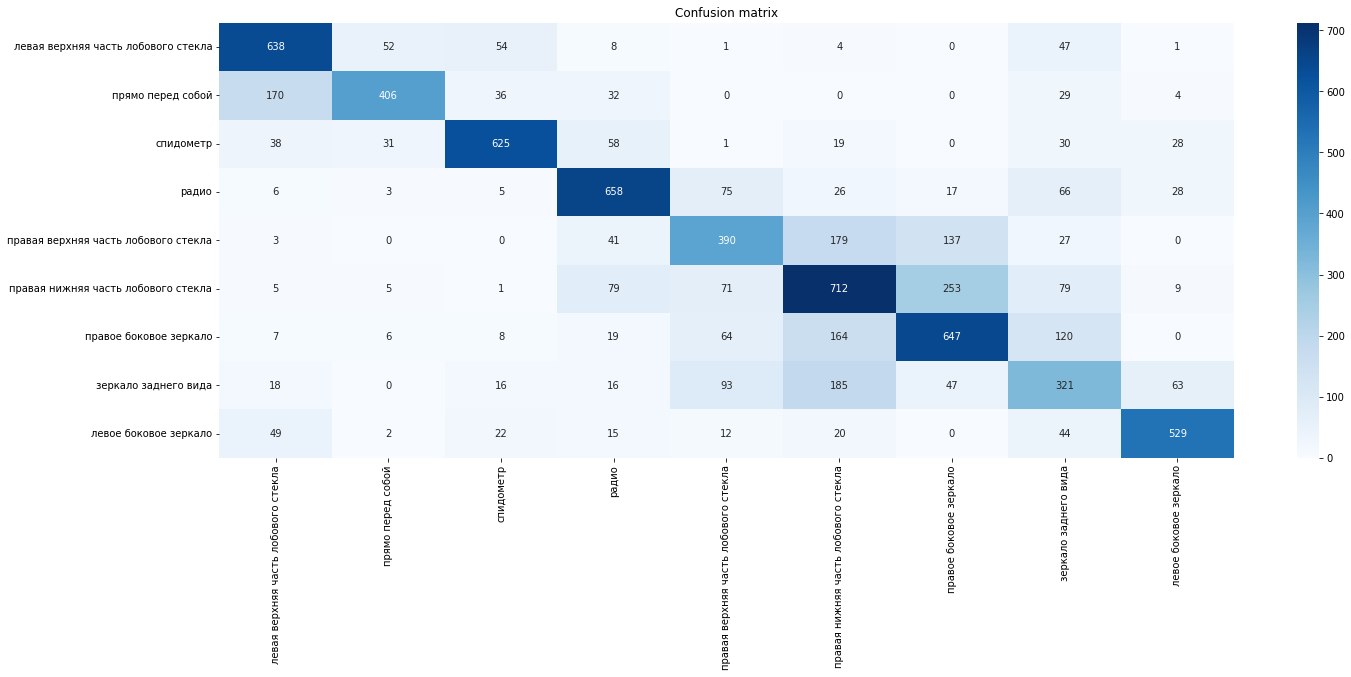

In [63]:
confusion = pd.crosstab(y_true, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion.columns = target
confusion.index = target

fig = plt.figure(figsize=(50,8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

In [64]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73       934
         1.0       0.60      0.80      0.69       505
         2.0       0.75      0.81      0.78       767
         3.0       0.74      0.71      0.73       926
         4.0       0.50      0.55      0.53       707
         5.0       0.59      0.54      0.56      1309
         6.0       0.63      0.59      0.61      1101
         7.0       0.42      0.42      0.42       763
         8.0       0.76      0.80      0.78       662

    accuracy                           0.64      7674
   macro avg       0.64      0.66      0.65      7674
weighted avg       0.64      0.64      0.64      7674



### MediaPipe + ML Classifier

In [ ]:
!pip install mediapipe

In [ ]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [ ]:
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
    image = cv2.imread('/kaggle/input/driver-gaze-in-the-wild/dgw/dgw/train/1/Sub100_vid1_frame33.png')
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print and draw face mesh landmarks on the image.
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
        # print('face_landmarks:', face_landmarks)
        mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_iris_connections_style())

        plt.figure()
        plt.grid(False)
        plt.imshow(annotated_image)
        plt.show()

In [ ]:
with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
    image = cv2.imread('/kaggle/input/driver-gaze-in-the-wild/dgw_faces/dgw_faces/train_faces/1/Sub100_vid1_frame33.png')
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    face_features = []
    
    for face_landmarks in results.multi_face_landmarks:
        for lm in face_landmarks.landmark:
            # print(str(lm).split()[1::2])
            face_features += str(lm).split()[1::2]
            
    print(len(face_features))

In [ ]:
def get_mediapipe_features(data_dir, annotation_file):
    x = []
    y = []
    
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,filename)
        X_global_features=[]
        imgs=[]
        # faces_only=[fn for fn in os.listdir(frames_dir) if 'noface' not in fn]
        
        for img_name in os.listdir(frames_dir):
            img_path = os.path.join(frames_dir, img_name)
            
            if img_path in annotation_file.iloc[:, 0].values:
                with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
                    image = cv2.imread(img_path)
                    # Convert the BGR image to RGB before processing.
                    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    face_features = []

                    if results.multi_face_landmarks != None:
                        for face_landmarks in results.multi_face_landmarks:
                            for lm in face_landmarks.landmark:
                                # print(str(lm).split()[1::2])
                                face_features += str(lm).split()[1::2]

                        x.append(face_features)
                        y.append(int(filename))
                
    x=np.array(x)
    y=np.array(y)
    print(x.shape,y.shape)
    return x,y

In [ ]:
# x_train_mediapipe, y_train_mediapipe = get_mediapipe_features(train_faces_dir, train_annotation)
# x_val_mediapipe, y_val_mediapipe = get_mediapipe_features(val_faces_dir, val_annotation)
x_test_mediapipe, y_test_mediapipe = get_mediapipe_features(train_faces_dir, test_annotation)

In [ ]:
x_train_norm = preprocessing.normalize(x_train_mediapipe,norm='l2')
x_val_norm = preprocessing.normalize(x_val_mediapipe,norm='l2')
x_test_norm = preprocessing.normalize(x_test_mediapipe,norm='l2')

In [ ]:
clf = svm.LinearSVC() #0.5 1.1 0.6
# clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)
   
clf.fit(x_train_norm, y_train_mediapipe)
y_pred_val = clf.predict(x_val_norm)
y_pred_test = clf.predict(x_test_norm)

print("Validation ccuracy:", metrics.accuracy_score(y_val_mediapipe, y_pred_val))
print("Test accuracy:", metrics.accuracy_score(y_test_mediapipe, y_pred_test))

In [ ]:
confusion_val = pd.crosstab(y_val_mediapipe, y_pred_val, rownames=['y_true_val'], colnames=['y_pred_val'])
confusion_val.columns = target
confusion_val.index = target

In [ ]:
fig = plt.figure(figsize=(50, 8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion_val, annot=True, cmap='Blues', fmt='g')

In [ ]:
confusion_test = pd.crosstab(y_test_mediapipe, y_pred_test, rownames=['y_true_val'], colnames=['y_pred_val'])
confusion_test.columns = target
confusion_test.index = target

In [ ]:
fig = plt.figure(figsize=(50, 8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion_test, annot=True, cmap='Blues', fmt='g')

### Неиспользуемый код

In [ ]:
train_faces = DriverFaces(train_annotation, train_dir, imgProcessing, transform)
val_faces = DriverFaces(val_annotation, val_dir, imgProcessing, transform)

In [ ]:
class DriverFaces(Dataset):
    def __init__(self, annotation_file, img_dir, img_processing, transform=None, target_transform=None):
        self.img_labels = annotation_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.imgProcessing = img_processing
        #self.mtcnn = mtcnn

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        # face = self.extract_face(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            face = self.transform(face)
        if self.target_transform:
            label = self.target_transform(label)
        return face, int(label)
    
    def extract_face(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bounding_boxes, _ = self.imgProcessing.detect_faces(img)

        if len(bounding_boxes)==0:
            print('No faces found')
        else:
            if len(bounding_boxes)>1:
                print('Too many faces (',len(bounding_boxes),') found')
                bounding_boxes=bounding_boxes[:1]

            b=[int(bi) for bi in bounding_boxes[0]]
            x1,y1,x2,y2=b[0:4]

            face_img=img[y1:y2,x1:x2,:]
            # image_with_bbox = cv2.rectangle(image, (x1, y1), (x2, y2),(0,0,0),1)

            return face_img